# Scenario Builder

In [1]:
using Pkg;
Pkg.activate("..")

  Activating project at `~/Documents/repos/GatekeeperFormationFlight.jl/examples`


In [2]:
using Revise
using GatekeeperFormationFlight

In [3]:
using StaticArrays
using YAML
using Plots
using Polynomials

In [4]:
include("./file_util.jl")
include("../3d_example_utils.jl")
include("./demo_util.jl")

Main.DemoUtil

## Create the Scenario

### Create the Obstacles

In [14]:
# Empty Vector of Obstacles
obstacles = Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}()

GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle[]

In [15]:
obs_1 = Cylinder(0.0, 0.0, 0.5)
push!(obstacles, obs_1)

# obs_2 = Sphere(2.5, 1.5, 1.5, 0.5)
# push!(obstacles, obs_2)

1-element Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}:
 Cylinder{Float64}([0.0, 0.0, 0.0], 0.5)

In [16]:
obstacles_dict = [FileUtil.obstacle_to_dict(obs) for obs in obstacles]

1-element Vector{Dict{String, Any}}:
 Dict("radius" => 0.5, "position" => [0.0, 0.0, 0.0], "type" => "Cylinder")

### Create the Gatekeeper Coefficients Object

In [17]:
# Create desired object using kwarg constructor
coeffs = GatekeeperCoefficients(
    switch_step_size = 0.25,
    reconnection_step_size = 0.125,
    max_Ts_horizon = 10.0,
    integration_max_step_size = 0.05,
    integration_step_size = 0.01,
    collision_check_step_size = 0.05
)

# Convert to dictionary with symbol keys
coeffs_dict = Dict(fieldnames(GatekeeperCoefficients) .=> getfield.(Ref(coeffs), fieldnames(GatekeeperCoefficients)))

Dict{Symbol, Float64} with 6 entries:
  :reconnection_step_size    => 0.125
  :max_Ts_horizon            => 10.0
  :integration_step_size     => 0.01
  :collision_check_step_size => 0.05
  :switch_step_size          => 0.25
  :integration_max_step_size => 0.05

### Create the Agent Settings

In [43]:
agent_settings = DemoUtil.AgentSettings(
    v_min = 0.8,
    v_max = 1.0,
    x_padding = 0.1,
    agent_radius = 0.15,
    turn_radius = 1.,
    pitch_limits = SVector(-pi / 4, pi / 4)
)

agent_settings_dict = Dict(fieldnames(DemoUtil.AgentSettings) .=> getfield.(Ref(agent_settings), fieldnames(DemoUtil.AgentSettings)))

Dict{Symbol, Any} with 6 entries:
  :turn_radius  => 1.0
  :pitch_limits => [-0.785398, 0.785398]
  :v_min        => 0.8
  :v_max        => 1.0
  :x_padding    => 0.1
  :agent_radius => 0.15

### Set Agent Offsets

In [44]:
sim_agents = Vector{DemoUtil.SimAgent}()

Main.DemoUtil.SimAgent[]

In [45]:
agent1 = DemoUtil.SimAgent(
    id = 1,
    offset = SVector(0.0, 0.0, 0.0, 0.0, 0.0)
)
agent2 = DemoUtil.SimAgent(
    id = 2,
    offset = SVector(-0.3, -0.6, 0.0, 0.0, 0.0)
)
agent3 = DemoUtil.SimAgent(
    id = 3,
    offset = SVector(-0.3, 0.6, 0.0, 0.0, 0.0)
)

push!(sim_agents, agent1)
push!(sim_agents, agent2)
push!(sim_agents, agent3)

3-element Vector{Main.DemoUtil.SimAgent}:
 Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(2, [-0.3, -0.6, 0.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(3, [-0.3, 0.6, 0.0, 0.0, 0.0])

In [46]:
sim_agents_out = [Dict(fieldnames(DemoUtil.SimAgent) .=> getfield.(Ref(sim_agent), fieldnames(DemoUtil.SimAgent))) for sim_agent in sim_agents]

3-element Vector{Dict{Symbol, Any}}:
 Dict(:offset => [0.0, 0.0, 0.0, 0.0, 0.0], :id => 1)
 Dict(:offset => [-0.3, -0.6, 0.0, 0.0, 0.0], :id => 2)
 Dict(:offset => [-0.3, 0.6, 0.0, 0.0, 0.0], :id => 3)

### Create the Scenario

In [47]:
scenario = DemoUtil.SimScenario(
    name = "demo_scenario",
    start_pose = SVector(-1.8, -1.2, 0.5, 0.0, 0.0),
    goal_pose = SVector(1.8, 1.2, 1.5, 0.0, 0.0),
    domain_min = SVector(-3.0, -2.0, 0.0), 
    domain_max = SVector(2.0, 2.0, 2.0)
)
scenario_dict = Dict(fieldnames(DemoUtil.SimScenario) .=> getfield.(Ref(scenario), fieldnames(DemoUtil.SimScenario)))

Dict{Symbol, Any} with 5 entries:
  :start_pose => [-1.8, -1.2, 0.5, 0.0, 0.0]
  :domain_min => [-3.0, -2.0, 0.0]
  :name       => "demo_scenario"
  :domain_max => [2.0, 2.0, 2.0]
  :goal_pose  => [1.8, 1.2, 1.5, 0.0, 0.0]

### Write YAML

In [48]:
output_object = Dict(
    "gatekeeper_coefficients" => coeffs_dict,
    "obstacles" => obstacles_dict,
    "agent_settings" => agent_settings_dict,
    "agents" => sim_agents_out,
    "scenario" => scenario_dict
)

YAML.write_file("scenarios/$(scenario_dict[:name]).yaml", output_object)


### Plot the Scenario

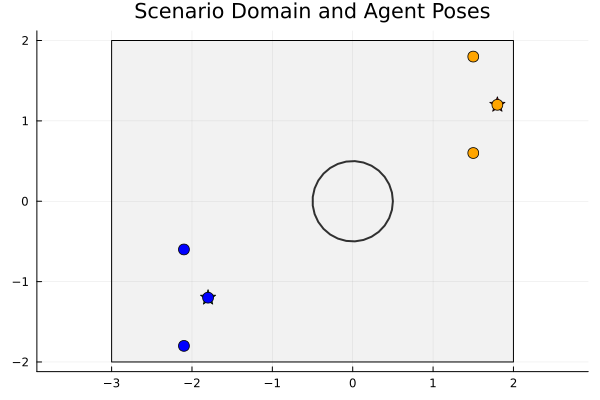

In [49]:
## 2D plot showing the scenario domain, and start & goal poses w/offsets

# Extract domain and poses
domain_min = scenario.domain_min
domain_max = scenario.domain_max
start_pose = scenario.start_pose
goal_pose = scenario.goal_pose

# Agent offsets
offsets = [agent.offset for agent in sim_agents]

# Plot domain as rectangle
p = plot(; legend=false, aspect_ratio=:equal, title="Scenario Domain and Agent Poses")
plot!(p, [domain_min[1], domain_max[1], domain_max[1], domain_min[1], domain_min[1]],
         [domain_min[2], domain_min[2], domain_max[2], domain_max[2], domain_min[2]],
         seriestype=:shape, fillalpha=0.1, color=:gray, label="Domain")

# Plot start and goal poses
scatter!(p, [start_pose[1]], [start_pose[2]], color=:green, marker=:star5, markersize=8, label="Start")
scatter!(p, [goal_pose[1]], [goal_pose[2]], color=:red, marker=:star5, markersize=8, label="Goal")

# Plot agent offsets at start
for (i, offset) in enumerate(offsets)
    scatter!(p, [start_pose[1] + offset[1]], [start_pose[2] + offset[2]],
             color=:blue, marker=:circle, markersize=6, label="Agent $i Start Offset")
end

# Plot agent offsets at goal
for (i, offset) in enumerate(offsets)
    scatter!(p, [goal_pose[1] + offset[1]], [goal_pose[2] + offset[2]],
             color=:orange, marker=:circle, markersize=6, label="Agent $i Goal Offset")
end

for obs in env.obstacles
    plot!(p, PlotCircle(obs), label = false, linedwidth = 2)
end

display(p)


## Load YAML

In [5]:
obj = YAML.load_file("scenarios/demo_scenario.yaml"; dicttype=Dict{Symbol, Any})

Dict{Symbol, Any} with 5 entries:
  :obstacles               => Dict{Symbol, Any}[Dict(:radius=>0.5, :position=>[…
  :gatekeeper_coefficients => Dict{Symbol, Any}(:reconnection_step_size=>0.125,…
  :agent_settings          => Dict{Symbol, Any}(:turn_radius=>0.5, :pitch_limit…
  :agents                  => Dict{Symbol, Any}[Dict(:offset=>[0.0, 0.0, 0.0, 0…
  :scenario                => Dict{Symbol, Any}(:start_pose=>[0.0, 0.0, 0.0, 0.…

In [6]:
coeffs_in = obj[:gatekeeper_coefficients]
gk_coeffs = GatekeeperCoefficients(; coeffs_in...)
obj[:gatekeeper_coefficients] = gk_coeffs

GatekeeperCoefficients{Float64}(10.0, 0.125, 0.05, 0.05, 0.01, 0.5)

In [7]:
objects_in = obj[:obstacles]
objects = [FileUtil.dict_to_obstacle(obs) for obs in objects_in]
obj[:obstacles] = objects

2-element Vector{GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle}:
 Cylinder{Float64}([1.5, 1.5, 0.0], 0.5)
 Sphere{Float64}([2.5, 1.5, 1.5], 0.5)

In [8]:
obj[:agent_settings] = DemoUtil.AgentSettings(; obj[:agent_settings]...)

Main.DemoUtil.AgentSettings(0.8, 1.0, 0.1, 0.125, 0.5, [-0.7853981633974483, 0.7853981633974483])

In [9]:
obj[:agents] = [DemoUtil.SimAgent(; agent...) for agent in obj[:agents]]

3-element Vector{Main.DemoUtil.SimAgent}:
 Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(2, [0.0, 0.0, 1.0, 0.0, 0.0])
 Main.DemoUtil.SimAgent(3, [0.0, 1.0, 0.0, 0.0, 0.0])

In [10]:
# @show obj[:scenario]
obj[:scenario] = DemoUtil.SimScenario(; obj[:scenario]...)

Main.DemoUtil.SimScenario("demo_scenario", [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 0.0, 0.0], [-1.0, -1.0, 0.0], [1.0, 1.0, 2.0])

In [11]:
# sim_env = DemoUtil.SimEnvironment(; obj...)
sim_env = DemoUtil.SimEnvironment(; obj...)

Main.DemoUtil.SimEnvironment(Main.DemoUtil.SimScenario("demo_scenario", [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 0.0, 0.0], [-1.0, -1.0, 0.0], [1.0, 1.0, 2.0]), Main.DemoUtil.AgentSettings(0.8, 1.0, 0.1, 0.125, 0.5, [-0.7853981633974483, 0.7853981633974483]), Main.DemoUtil.SimAgent[Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(2, [0.0, 0.0, 1.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(3, [0.0, 1.0, 0.0, 0.0, 0.0])], GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle[Cylinder{Float64}([1.5, 1.5, 0.0], 0.5), Sphere{Float64}([2.5, 1.5, 1.5], 0.5)], GatekeeperCoefficients{Float64}(10.0, 0.125, 0.05, 0.05, 0.01, 0.5), nothing, nothing, nothing, nothing, nothing)

## Testing with DemoUtil

In [49]:
include("./demo_util.jl")

Main.DemoUtil

In [50]:
env = DemoUtil.load_env("scenarios/demo_scenario.yaml")

Main.DemoUtil.SimEnvironment(Main.DemoUtil.SimScenario("demo_scenario", [-1.8, -1.2, 0.5, 0.0, 0.0], [1.8, 1.2, 1.5, 0.0, 0.0], [-3.0, -2.0, 0.0], [2.0, 2.0, 2.0]), Main.DemoUtil.AgentSettings(0.8, 1.0, 0.1, 0.15, 1.0, [-0.7853981633974483, 0.7853981633974483]), Main.DemoUtil.SimAgent[Main.DemoUtil.SimAgent(1, [0.0, 0.0, 0.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(2, [-0.3, -0.6, 0.0, 0.0, 0.0]), Main.DemoUtil.SimAgent(3, [-0.3, 0.6, 0.0, 0.0, 0.0])], GatekeeperFormationFlight.Obstacles.AbstractStaticObstacle[Cylinder{Float64}([0.0, 0.0, 0.0], 0.5)], GatekeeperCoefficients{Float64}(10.0, 0.125, 0.05, 0.05, 0.01, 0.25), nothing, nothing, nothing, nothing, nothing)

In [51]:
success = DemoUtil.solve_leader_path!(env)

true

### Plot the Solved Path

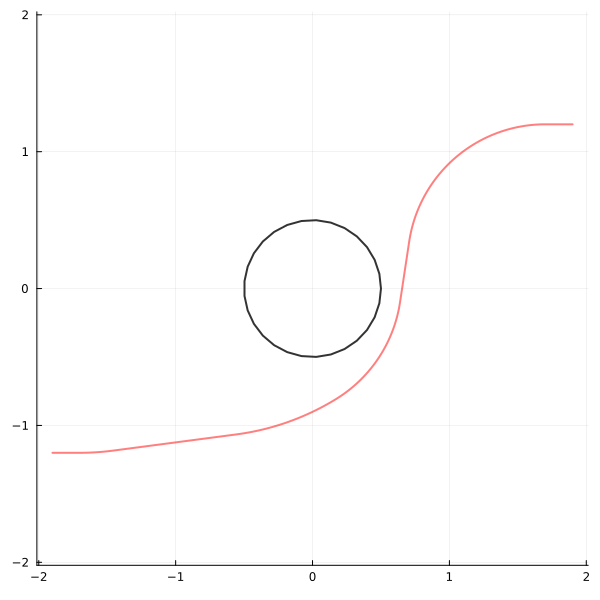

In [52]:
p = ExampleUtils3D.visualize_baseline_2d(env.obstacles, env.leader_path)
# @show env.obstacles

### Solve the GK Problem & Plot

In [53]:
success = DemoUtil.solve_gk_problem!(env)

      Multi-Agent Gatekeeper Simulation        
Number of agents: 3
Timespan: [0.0, 5.31003822130597]


[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Constructing candidate trajectory for agent 1 at x0 = [-1.8, -1.2, 0.5, 0.0, 0.0]
[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Constructing candidate trajectory for agent 2 at x0 = [-2.1, -1.7999999999999998, 0.5, 0.0, 0.0]
[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Constructing candidate trajectory for agent 3 at x0 = [-2.1, -0.6, 0.5, 0.0, 0.0]
[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Backup time 2.5143231476874126 failed for agent 3. Trying again.
[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Backup time 2.2643231476874126 failed for agent 3. Trying again.
[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Backup time 2.0143231476874126 failed for agent 3. Trying again.
[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Backup time 1.7643231476874126 failed for agent 3. Trying again.
[ GatekeeperFormationFlight.MultiGatekeeper | Info ] : Backup time 1.5143231476874126 failed f

true

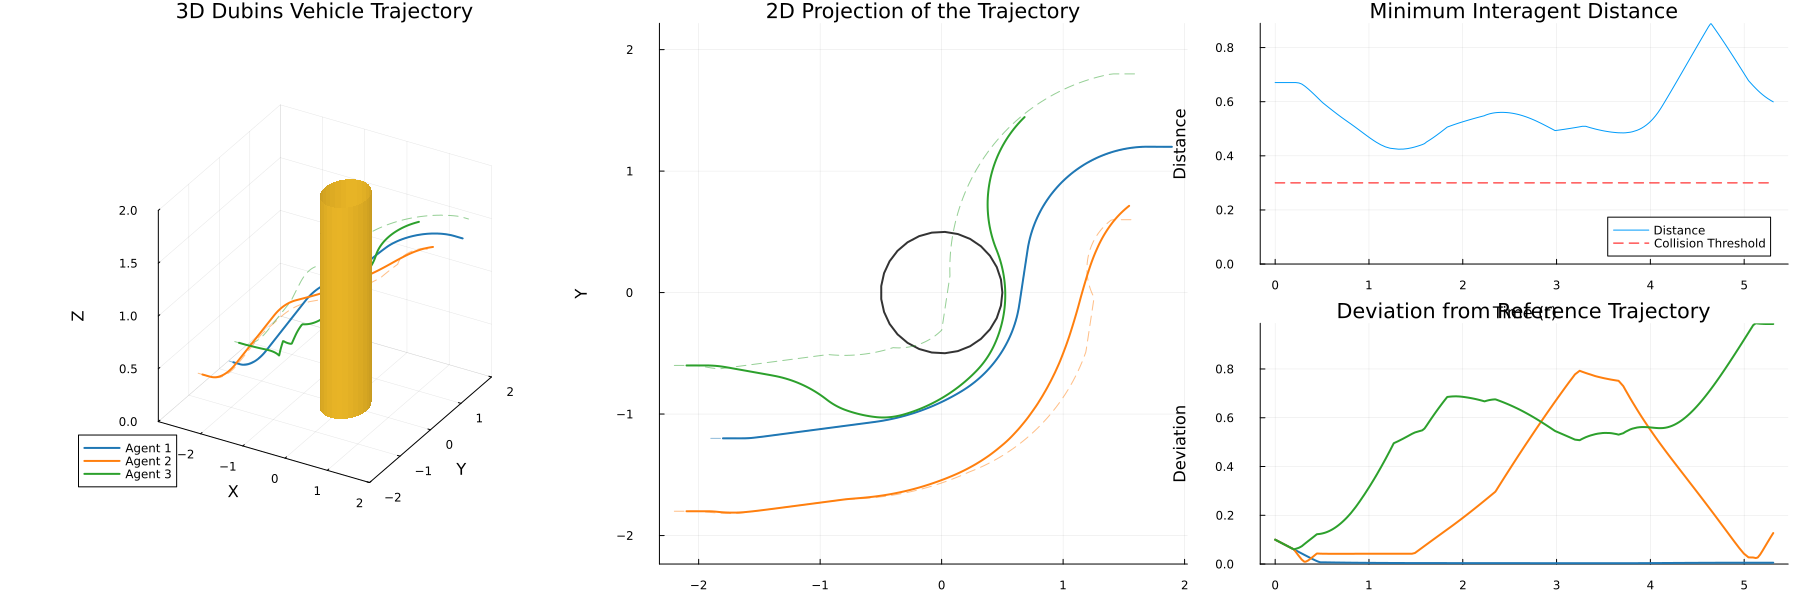

In [60]:
p = ExampleUtils3D.plot_interagent_solution(env.solution, env.gk; dims_min=env.scenario.domain_min, dims_max=env.scenario.domain_max)
display(p)

### Write Solution to File

In [55]:
DemoUtil.write_to_file(env, "scenarios/demo_scenario_solution.csv")

Row,pos_z,time,pos_y,heading,agent_id,pos_x
,Float64,Float64,Float64,Float64,Int64,Float64
1,0.5,0.0,-1.2,0.0,1,-1.8
2,0.5,0.0,-1.8,0.0,2,-2.1
3,0.5,0.0,-0.6,0.0,3,-2.1
4,0.5,0.000941613,-1.2,0.0,1,-1.796
5,0.5,0.000941613,-1.8,0.0,2,-2.096
6,0.5,0.000941613,-0.6,0.0,3,-2.096
7,0.5,0.00188323,-1.2,0.0,1,-1.792
8,0.5,0.00188323,-1.8,0.0,2,-2.092
9,0.5,0.00188323,-0.6,0.0,3,-2.092


In [ ]:
chunk_polys = DemoUtil.fit_polynomials(env.data, chunk_size=40)

213-element Vector{Any}:
 (agent_id = 1.0, duration = 0.6779612217394931, var"x^0" = -1.8000000000000012, var"x^1" = 0.14160101923487017, var"x^2" = -5.924697382242303e-13, var"x^3" = 3.805102386643103e-12, var"x^4" = -1.3240778943877865e-11, var"x^5" = 2.5530701381907297e-11, var"x^6" = -2.5590116683298918e-11, var"x^7" = 1.0379394403358413e-11, var"y^0" = -1.2000000000000008, var"y^1" = 3.0440394205444376e-14, var"y^2" = -4.2403883824052457e-13, var"y^3" = 2.7547203462900667e-12, var"y^4" = -9.454380359781205e-12, var"y^5" = 1.766592287651922e-11, var"y^6" = -1.6981729227887582e-11, var"y^7" = 6.572422103785844e-12, var"z^0" = 0.4999999999999999, var"z^1" = 5.435784679543805e-15, var"z^2" = -7.572122111438032e-14, var"z^3" = 4.919143475517989e-13, var"z^4" = -1.6882822071037867e-12, var"z^5" = 3.154629085092718e-12, var"z^6" = -3.0324516478370695e-12, var"z^7" = 1.1736468042474722e-12, var"yaw^0" = 0.0, var"yaw^1" = 0.0, var"yaw^2" = 0.0, var"yaw^3" = 0.0, var"yaw^4" = 0.0, var"yaw^5

### Plot the Chunk Polynomials

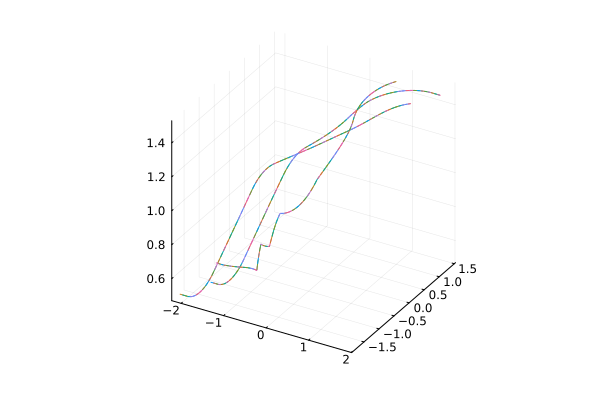

In [59]:
p = plot(legend = false)
for pnom in chunk_polys
    # reconstruct polynomial from coefficients
    px = Polynomial(values(pnom)[3:10])
    py = Polynomial(values(pnom)[11:18])
    pz = Polynomial(values(pnom)[19:26])

    plot!(
        p,
        τ -> px(τ),
        τ -> py(τ),
        τ -> pz(τ),
        0:0.01:pnom.duration,
    )
end

display(p)

### Write the Polynomials to a File

In [30]:
DemoUtil.write_polynomials_to_file(chunk_polys, "scenarios/$(env.scenario.name)_trajectories.csv")

"scenarios/demo_scenario_trajectories.csv"